#Optimize API

Suppose you've written an algorithm that's developed a signal (for example, a [Pipeline Factor](https://www.quantopian.com/tutorials/pipeline#lesson3)) that's predictive of future asset returns. You might think that the hard part is over, but you're still left with the daunting task of translating your signal into an algorithm that can turn a profit while also managing risk exposures.

Traditionally in quantitative finance, the solution to the problem of maximizing returns while constraining risk has been to employ some form of [Portfolio Optimization](https://en.wikipedia.org/wiki/Portfolio_optimization), but performing sophisticated optimizations is challenging on today's Quantopian.

Python libraries like [scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html), [CVXOPT](http://cvxopt.org/), and [CVXPY](http://www.cvxpy.org/en/latest/) (all available on Quantopian today) provide generic tools for solving optimization problems. These libraries are powerful and flexible, but it takes significant expertise to convert the data structures available on Quantopian into the specific formats understood by these libraries.

The [**Optimize API**](https://www.quantopian.com/help#optimize-title) is a suite of tools for defining and solving portfolio optimization problems directly in terms of financial domain concepts. Users interact with the Optimize API by providing an `Objective` and a list of `Constraint` objects to an API function that runs a portfolio optimization. The Optimize API hides most of the complex mathematics of portfolio optimization, allowing users to think in terms of high-level concepts like “maximize expected returns” and “constrain sector exposure” instead of abstract matrix products.

### What is Portfolio Optimization?

Many algorithms written on Quantopian reach a point where they need to solve an **optimization problem** of the following form:

Given a list of stocks, choose a vector,

$$w$$ 

of weights in each stock that maximizes (or minimizes) an **objective** function,

$$F(w)$$ 

subject to a set of inequality **constraints**,

\begin{align} 
C_1(w) &\leq h_1 \\ 
C_2(w) &\leq h_2    \\
&\dots           \\
C_N(w) &\leq h_N    \\
\end{align}

####Example:

An algorithm builds a model that predicts expected returns for a list of stocks. The algorithm wants to allocate a limited amount of capital to those stocks in a way that gives it the greatest possible expected return without placing too big a bet on any single stock.

We can frame this as an optimization problem as follows:

Given an expected returns vector $r = [r_0, r_1, \dots, r_n]$, a maximum single-stock weight $w_{max}$, and a maximum total weight $W_{max}$, find a portfolio weight vector $w = [w_0, w_1, \dots, w_n]$ that solves the following system:

\begin{align}
\text{maximize}&& \\
&&r \cdot w \\
\text{subject to}&& \\
&&w_i &\leq w_{max} && 0 \leq i \leq n\\
&& \sum_{i=0}^{n}{|w_i|} &\leq W_{max}
\end{align}

A more sophisticated algorithm might introduce a more complex objective (e.g. "maximize return with a penalty applied for expected volatility"), or it might introduce more complex constraints (e.g. limit exposure to particular market sectors).

## API Overview

The Optimize API is defined in the [**`quantopian.optimize`**](https://www.quantopian.com/help#module-quantopian.optimize) module.

The `optimize` module has three important concepts:

1. [**`Objectives`**](https://www.quantopian.com/help#objectives): classes that define the function to be minimized or maximized by the optimizer.
2. [**`Constraints`**](https://www.quantopian.com/help#objectives): classes that define constraints that the optimizer must respect when finding a new portfolio.
3. [**`Entry Points`**](https://www.quantopian.com/help#running-optimizations), functions that actually run optimizations. The Optimize API has three entrypoints:
  - `calculate_optimal_portfolio`, the primary entrypoint in research notebooks.
  - `order_optimal_portfolio`, the primary entrypoint in trading algorithms.
  - `run_optimization`, a lower-level entrypoint useful for debugging.

To run a portfolio optimization **in a notebook**, you call `calculate_optimal_portfolio` and provide  up to three inputs: 

- An `Objective` to optimize.
- A list of `Constraint`s to enforce.
- (optionally) A [pandas Series](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html) containing weights for the current portfolio. If no current weights are provided, the optimization proceeds assuming that the current portfolio is empty.

To run a portfolio optimization **in a trading algorithm**, you call `order_optimal_portfolio` instead. 
`order_optimal_portfolio` accepts two inputs:

- An `Objective` to optimize (same as above).
- A list of `Constraints` to enforce (same as above).

It is also possible to call `calculate_optimal_portfolio` from a trading algorithm to compute the portfolio that `order_optimal_portfolio` would attempt to achieve if invoked.

In [1]:
import quantopian.optimize as opt
print opt.calculate_optimal_portfolio.__doc__


    Calculate optimal portfolio weights given ``objective`` and ``constraints``.

    Parameters
    ----------
    objective : Objective
        The objective to be minimized or maximized.
    constraints : list[Constraint]
        List of constraints that must be satisfied by the new portfolio.
    current_portfolio : pd.Series, optional
        A Series containing the current portfolio weights, expressed as
        percentages of the portfolio's liquidation value.
    
        When called from a trading algorithm, the default value of
        ``current_portfolio`` is the algorithm's current portfolio.
    
        When called interactively, the default value of ``current_portfolio``
        is an empty portfolio.

    Returns
    -------
    optimal_portfolio : pd.Series
        A Series containing portfolio weights that maximize (or minimize)
        ``objective`` without violating any ``constraints``. Weights should be
        interpreted in the same way as ``current_portfolio``.

Lists of the currently available objectives and constraints can be found under **`quantopian.optimize.objectives`** and **`quantopian.optimize.constraints`**, respectively.

In [2]:
opt.objectives

[quantopian.optimize.objectives.MaximizeAlpha,
 quantopian.optimize.objectives.Objective,
 quantopian.optimize.objectives.TargetWeights]

In [3]:
opt.constraints

[quantopian.optimize.constraints.Basket,
 quantopian.optimize.constraints.CannotHold,
 quantopian.optimize.constraints.Constraint,
 quantopian.optimize.constraints.DollarNeutral,
 quantopian.optimize.constraints.FactorExposure,
 quantopian.optimize.constraints.FixedWeight,
 quantopian.optimize.constraints.Frozen,
 quantopian.optimize.constraints.LongOnly,
 quantopian.optimize.constraints.MaxGrossExposure,
 quantopian.optimize.constraints.MaxTurnover,
 quantopian.optimize.constraints.NetExposure,
 quantopian.optimize.constraints.NetGroupExposure,
 quantopian.optimize.constraints.Pair,
 quantopian.optimize.constraints.PositionConcentration,
 quantopian.optimize.constraints.ReduceOnly,
 quantopian.optimize.constraints.ShortOnly]

### Example: Maximize Expected Returns with Exposure and Concentration Constraints

Let's look at how we can use the `optimize` API to solve the example outlined above:

> An algorithm builds a model that predicts expected returns for a list of stocks. The algorithm wants to allocate a limited amount of capital to those stocks in a way that gives it the greatest possible expected return without placing too big a bet on any single stock.

Since we're assuming we already have a returns model, we'll just use random numbers for this example.

In [4]:
import numpy as np
import pandas as pd

def fancy_returns_model(assets):
    """Not actually fancy."""
    # Generate a random number for each asset.
    rng = np.random.RandomState(5)
    return pd.Series(index=assets, data=rng.randn(len(assets)))

We'll also add a few utility functions for plotting portfolio weights.

In [5]:
def draw_asset_barplot(weights, title, plot_kwargs=None):
    """Draw a bar plot from a Series with Asset labels."""
    return draw_barplot(
        weights, 
        title, 
        xticks=[asset.symbol for asset in weights.index],
        plot_kwargs=plot_kwargs, 
    )

def draw_barplot(weights, title, xticks=None, plot_kwargs=None):
    """Draw a bar plot from a pd.Series."""
    
    # Draw the plot. Forward plot_kwargs (if provided) as keywords to ``plot``.
    axes = weights.plot(kind='bar', rot=0, fontsize=12, **(plot_kwargs or {}))
    axes.grid(False, axis='x')
    
    # Set a title.
    axes.set_title(title, {'fontsize': 14})
    
    # Set xtick labels, if provided.
    if xticks is not None:
        axes.set_xticklabels(xticks)

    return axes

In [6]:
# Choose a small universe to make the graphs manageable.
universe = symbols(
    ['AAPL', 'MSFT', 'TWTR', 'BP', 'XOM', 'MCD', 'QSR'],
    symbol_reference_date='2016-10-07',
)
                     
empty_portfolio = pd.Series(index=universe, data=0.0)
expected_returns = fancy_returns_model(universe)

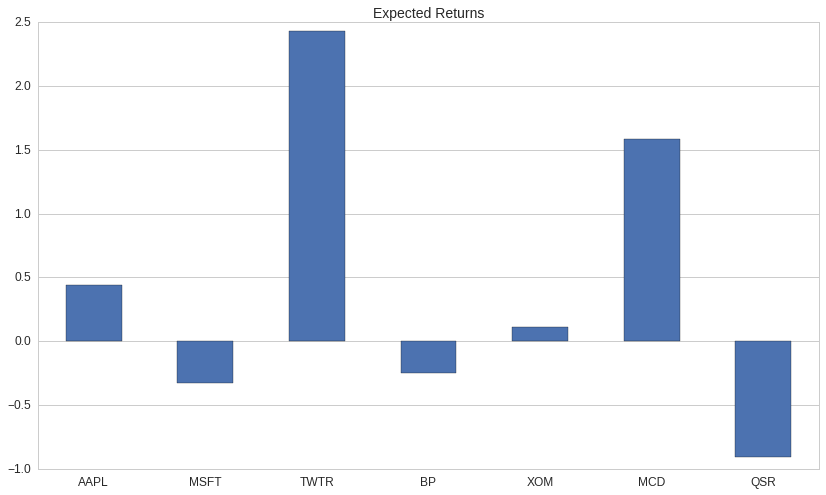

In [7]:
draw_asset_barplot(expected_returns, 'Expected Returns');

Since our goal is to maximize a function directly proportional to asset returns, we'll use **`opt.MaximizeAlpha`** as our objective function.

In [8]:
print opt.MaximizeAlpha.__doc__


    Objective that maximizes ``weights.dot(alphas)`` for an alpha vector.

    Ideally, ``alphas`` should contain coefficients such that ``alphas[asset]``
    is proportional to the expected return of ``asset`` for the time horizon
    over which the target portfolio will be held.

    In the special case that ``alphas`` is an estimate of expected returns for
    each asset, this objective simply maximizes the expected return of the
    total portfolio.

    Parameters
    ----------
    alphas : pd.Series[Asset -> float] or dict[Asset -> float]
        Map from assets to alpha coefficients for those assets.

    Notes
    -----
    This objective should almost always be used with a `MaxGrossExposure`
    constraint, and should usually be used with a `PositionConcentration`
    constraint.

    Without a constraint on gross exposure, this objective will raise an error
    attempting to allocate an unbounded amount of capital to every asset with a
    nonzero alpha.

    Without a cons

In [9]:
maximize_returns = opt.MaximizeAlpha(expected_returns)
maximize_returns

`Objective` classes can render themselves in mathematical notation via the `.math` property:

In [10]:
maximize_returns.math

The documentation for `MaximizeAlpha` warns us that we need to put a constraint on the gross exposure of our portfolio or else the optimizer will try to allocate an unbounded amount of capital, so we'll add a **`MaxGrossExposure`** constraint as well.

In [11]:
print opt.MaxGrossExposure.__doc__


    Constraint on the maximum gross exposure for the portfolio.

    Requires that the sum of the absolute values of the portfolio weights be
    less than ``max``.

    Parameters
    ----------
    max : float
        The maximum gross exposure of the portfolio.

    Examples
    --------
    ``MaxGrossExposure(1.5)`` constrains the total value of the
    portfolios longs and shorts to be no more than 1.5x the current portfolio
    value.
    


In [12]:
def optimal_portfolio_constrained_exposure_only():
    """Calculate the optimal portfolio if we're only constrained by gross exposure."""
    
    # Our objective function.
    objective = opt.MaximizeAlpha(expected_returns)
    
    # A list containing our constraints.
    constraints = [opt.MaxGrossExposure(1.0)]
    
    return opt.calculate_optimal_portfolio(objective, constraints, empty_portfolio)

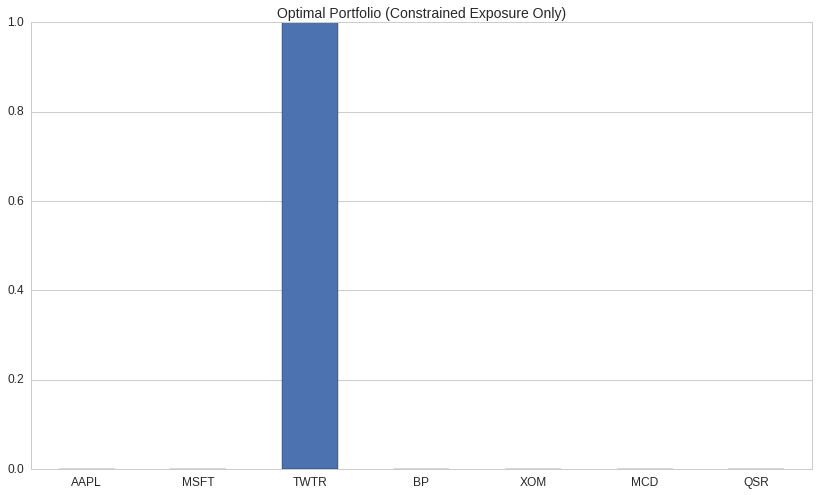

In [13]:
constrained_exposure_pf = optimal_portfolio_constrained_exposure_only()
draw_asset_barplot(constrained_exposure_pf, 'Optimal Portfolio (Constrained Exposure Only)');

With no constraints other than maximizing expected return, the optimizer decided to allocate all of our capital to a single long position in `TWTR`. While this might be an acceptable portfolio for someone of a gambling disposition, we'd probably rather not put all our eggs in one basket.

We can force the optimizer to diversify our portfolio by adding a **`PositionConcentration`** constraint:

In [14]:
print opt.PositionConcentration.__doc__


    Constraint enforcing minimum/maximum position weights.

    Parameters
    ----------
    min_weights : pd.Series[Asset -> float] or dict[Asset -> float]
        Map from asset to minimum position weight for that asset.
    max_weights : pd.Series[Asset -> float] or dict[Asset -> float]
        Map from asset to maximum position weight for that asset.
    default_min_weight : float, optional
        Value to use as a lower bound for assets not found in ``min_weights``.
        Default is 0.0.
    default_max_weight : float, optional
        Value to use as a lower bound for assets not found in ``max_weights``.
        Default is 0.0.
    etf_lookthru : pd.DataFrame, optional
        Indexed by constituent assets x ETFs, expresses the weight of each
        constituent in each ETF.

        A DataFrame containing ETF constituents data. Each column of the frame
        should contain weights (from 0.0 to 1.0) representing the holdings for
        an ETF. Each row should contain weig

In [15]:
print opt.PositionConcentration.with_equal_bounds.__doc__


        Special case constructor that applies static lower and upper bounds to
        all assets.

        ::

            PositionConcentration.with_equal_bounds(min, max)

        is equivalent to::

            PositionConcentration(pd.Series(), pd.Series(), min, max)

        Parameters
        ----------
        min : float
            Minimum position weight for all assets.
        max : float
            Maximum position weight for all assets.
        


In [16]:
# Allow 15% of our liquidation value to be in any single short position.
# Allow 30% of our liquidation value to be in any single long position.
# Try changing these parameters to see how they change the results!
MIN_POSITION_WEIGHT = -0.15
MAX_POSITION_WEIGHT = 0.30

def optimal_portfolio_constrained_exposure_and_concentration():
    """Calculate the optimal portfolio if we're constrained by exposure and concentration."""
    objective = opt.MaximizeAlpha(expected_returns)
    constraints = [
        opt.MaxGrossExposure(1.0),
        opt.PositionConcentration.with_equal_bounds(
            min=MIN_POSITION_WEIGHT, 
            max=MAX_POSITION_WEIGHT,
        )
    ]
    return opt.calculate_optimal_portfolio(objective, constraints, empty_portfolio)

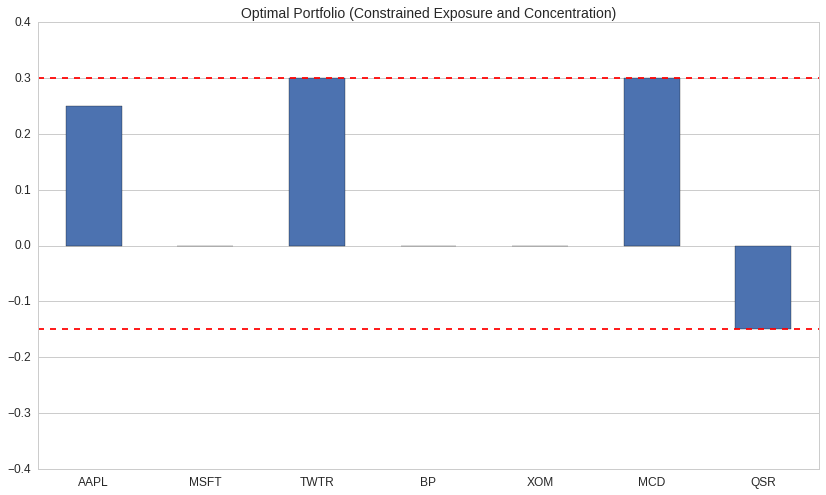

In [17]:
constrained_concentration_pf = optimal_portfolio_constrained_exposure_and_concentration()
plot = draw_asset_barplot(
    constrained_concentration_pf, 
    "Optimal Portfolio (Constrained Exposure and Concentration)",
    {'ylim': (-MAX_POSITION_WEIGHT - 0.1, MAX_POSITION_WEIGHT + 0.1)},
)
plot.axhline(MIN_POSITION_WEIGHT, color='r', linestyle='dashed')
plot.axhline(MAX_POSITION_WEIGHT, color='r', linestyle='dashed');

With position size constraints, our portfolio is significantly more diverse than before.  The optimizer was forced to cap the long allocations to `TWTR` and `GM` at 30% of NLV (Net Liquidation Value), and it was forced to cap the short allocations to `MCD` and `BK` at 15% NLV.  The remaining 10% under the gross exposure cap went to `AAPL`.

### Adding Sector Constraints

Eyeballing these distributions a bit, we might notice that we're heavily exposed to the technology and food service industries.  We can confirm that concern by using `Pipeline` to grab sector codes for our portfolio.

In [18]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import StaticAssets
from quantopian.research import run_pipeline


def get_sector_names(stocks, date):
    """Get sector codes for a set of stocks for a particular date."""
    result = run_pipeline(
        Pipeline({'sector': Sector()}, screen=StaticAssets(stocks)),
        start_date=date,
        end_date=date
    )
    # result will have a pd.MultiIndex whose first level just contains `date`.
    # Drop the first level so that we just get assets as our index.
    sector_codes = result['sector'].reset_index(level=0, drop=True)
    
    # Convert integral sector codes to human-readable strings by doing a lookup
    # from Sector.SECTOR_NAMES, which is a dict mapping codes to strings.
    #
    # This is purely for readability of the charts below. 
    # We could proceed with the rest of the notebook using sector codes and it would work just fine.
    return sector_codes.map(Sector.SECTOR_NAMES)

In [19]:
sector_names = get_sector_names(universe, '2016-10-07')
sector_names

Equity(24 [AAPL])              TECHNOLOGY
Equity(4707 [MCD])      CONSUMER_CYCLICAL
Equity(5061 [MSFT])            TECHNOLOGY
Equity(8347 [XOM])                 ENERGY
Equity(19675 [BP])                 ENERGY
Equity(45815 [TWTR])           TECHNOLOGY
Equity(48215 [QSR])     CONSUMER_CYCLICAL
Name: sector, dtype: object

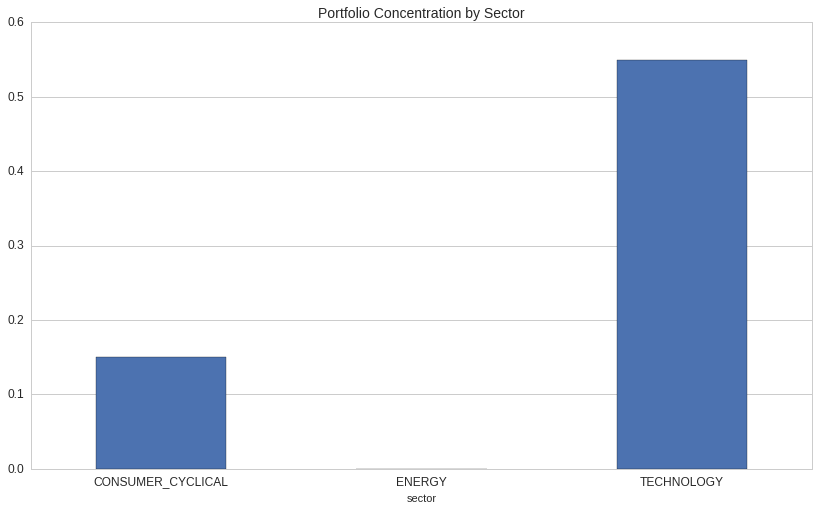

In [20]:
def plot_sector_exposure(pf, sectors):
    return draw_barplot(
        pf.groupby(sectors).sum(),
        'Portfolio Concentration by Sector',
    );

plot_sector_exposure(constrained_concentration_pf, sector_names);

As we suspected, we're heavily exposed to the technology sector, and we're moderately exposed to cyclical consumer goods.

We can tell the optimizer to try to build a sector neutral portfolio by adding a `NetGroupExposure` constraint:

In [21]:
print opt.NetGroupExposure.__doc__


    Constraint requiring bounded net exposure to groups of assets.

    Groups are defined by map from (asset -> label). Each unique label
    generates a constraint specifying that the sum of the weights of assets
    mapped to that label should fall between a lower and upper bounds.

    Min/Max group exposures are specified as maps from (label -> float).

    Examples of common group labels are sector, industry, and country.

    Parameters
    ----------
    labels : pd.Series[Asset -> object] or dict[Asset -> object]
        Map from asset -> group label.
    min_weights : pd.Series[object -> float] or dict[object -> float]
        Map from group label to minimum net exposure to assets in that group.
    max_weights : pd.Series[object -> float] or dict[object -> float]
        Map from group label to maximum net exposure to assets in that group.
    etf_lookthru : pd.DataFrame, optional
        Indexed by constituent assets x ETFs, expresses the weight of each
        constituent

In [22]:
ALL_SECTOR_NAMES = Sector.SECTOR_NAMES.values()
MIN_SECTOR_EXPOSURE = -0.0001
MAX_SECTOR_EXPOSURE = 0.0001

def optimal_portfolio_sector_neutral():
    """
    Calculate the optimal portfolio if we're constrained by exposure, concentration,
    and sector neutrality.
    """
    objective = opt.MaximizeAlpha(expected_returns)
    constraints = [
        opt.MaxGrossExposure(1.0),
        opt.PositionConcentration.with_equal_bounds(
            min=MIN_POSITION_WEIGHT, 
            max=MAX_POSITION_WEIGHT,
        ),
        opt.NetPartitionExposure(
            labels=sector_names,
            min_weights={sector: MIN_SECTOR_EXPOSURE for sector in ALL_SECTOR_NAMES},
            max_weights={sector: MAX_SECTOR_EXPOSURE for sector in ALL_SECTOR_NAMES},
        )
    ]
    return opt.calculate_optimal_portfolio(objective, constraints, empty_portfolio)

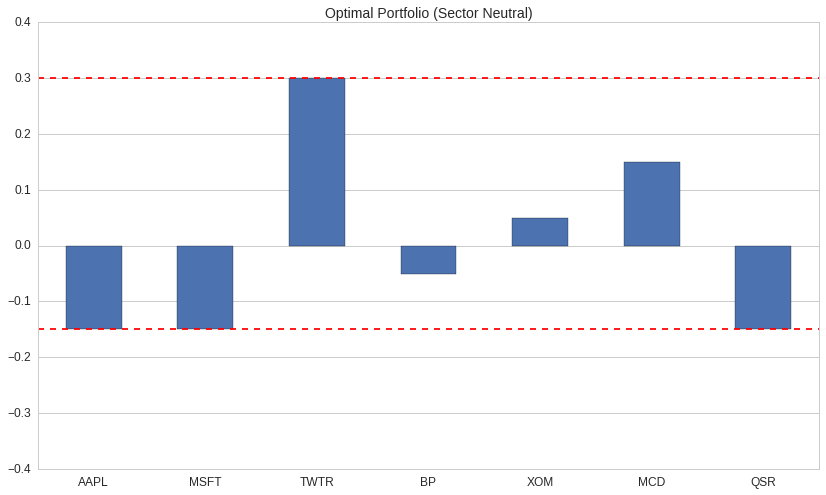

In [23]:
optimal_sector_neutral_pf = optimal_portfolio_sector_neutral()
plot = draw_asset_barplot(
    optimal_sector_neutral_pf, 
    'Optimal Portfolio (Sector Neutral)',
    {'ylim': (-MAX_POSITION_WEIGHT - 0.1, MAX_POSITION_WEIGHT + 0.1)},
)
plot.axhline(MIN_POSITION_WEIGHT, color='r', linestyle='dashed')
plot.axhline(MAX_POSITION_WEIGHT, color='r', linestyle='dashed');

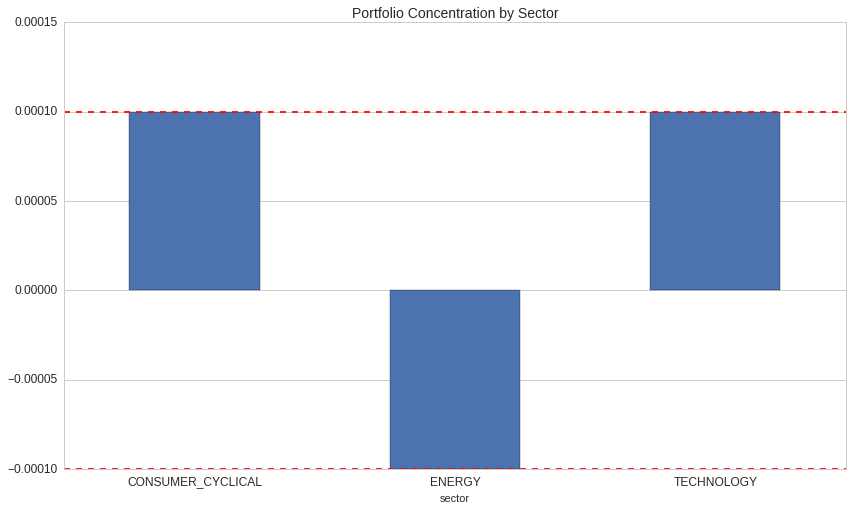

In [24]:
plot = plot_sector_exposure(optimal_sector_neutral_pf, sector_names);
plot.axhline(MIN_SECTOR_EXPOSURE, color='r', linestyle='dashed')
plot.axhline(MAX_SECTOR_EXPOSURE, color='r', linestyle='dashed');

With our partition exposure constraint in place, the optimizer chooses to hedge our large `TWTR` position with shorts in `AAPL` in `MSFT`. The optimizer also reigns in the large long in `MCD` from 30% to 15%, because our 15% short exposure constraint prevents us from getting a equal-sized hedge in `QSR`, which is the only other `CONSUMER_CYCLICAL` stock in our universe. That leaves 10% of our capital unallocated, so the optimizer divides it evenly into a pair on `BP` and `XOM`.

### Constraining Risk Factor Exposures

So far we've looked at constraining our portfolio by restricting how much value we allow the optimizer to allocate to groupings of assets at various levels of granularity:

- We used `MaxGrossExposure` to limit the amount of value the optimizer allocated to the largest possible group: the group of **all assets**.
- On the other end of the spectrum, we used `PositionConcentration` to limit how much value the optimizer allocated to the smallest possible groups: the groups containing individual assets.
- Between these two extremes, we used `NetGroupExposure` to control how much value the optimizer allocated to any single sector.

While these are all reasonable applications of the Optimize API, sometimes we want control our portfolio in ways that are more sophisticated than just controlling the value allocated to particular groups of assets.

A different technique for controlling risk is to associate each asset in our portfolio with a set of **risk factors** that describe how an asset's price has moved historically with respect to some common source of risk. For each risk factor, we can then set upper and lower bounds on the **factor-weighted** exposure of our portfolio.

The most commonly-used risk factor is market beta, which in the simplest case is calculated as the slope of a linear regression between an asset's returns and the returns of "the market". Other common risk factors are "size" (measured as a function of market cap, for example) and "value".

In [25]:
from quantopian.pipeline.factors import RollingLinearRegressionOfReturns
from quantopian.pipeline.data import Fundamentals

def get_risk_factors(stocks, date):
    # Measure beta as the slope of a linear regression of 60 days of daily close-to-close returns.
    # Each asset's returns are regressed against the returns of SPY.
    empirical_regression_coeffs = RollingLinearRegressionOfReturns(
        target=symbols('SPY'),
        returns_length=2,
        regression_length=60,
        mask=StaticAssets(stocks),
    )
    # RollingLinearRegressionOfReturns calculates a bunch of coefficients, 
    # but we only care about beta for this example.
    empirical_beta = empirical_regression_coeffs.beta
    
    # Measure size by taking the z-score of the log of market cap.
    # Taking the log of market cap is common because company sizes are
    # distributed exponentially.
    log_mcap_zscore = Fundamentals.market_cap.latest.log().zscore()
    
    # Measure value using book value yield.
    book_value_yield = Fundamentals.book_value_yield.latest.zscore()
    
    factor_terms = {
        'market': empirical_beta,
        'size': log_mcap_zscore,
        'value': book_value_yield,
    }
    
    result = run_pipeline(
        Pipeline(factor_terms, screen=StaticAssets(stocks)),
        start_date=date,
        end_date=date
    )
    # Drop dates from the index of the returned frame.
    return result.reset_index(level=0, drop=True)

In [26]:
risk_factors = get_risk_factors(universe, '2016-10-07')
risk_factors.head()

,market,size,value
Equity(24 [AAPL]),0.881295,3.049261,-0.035366
Equity(4707 [MCD]),0.566868,2.210673,-0.062235
Equity(5061 [MSFT]),1.088901,2.908003,-0.041585
Equity(8347 [XOM]),0.933150,2.807673,0.000507
Equity(19675 [BP]),1.039710,2.277613,0.047715


Lets look at how our how heavily our previous sector-neutral portfolio is exposed to these risk factors:

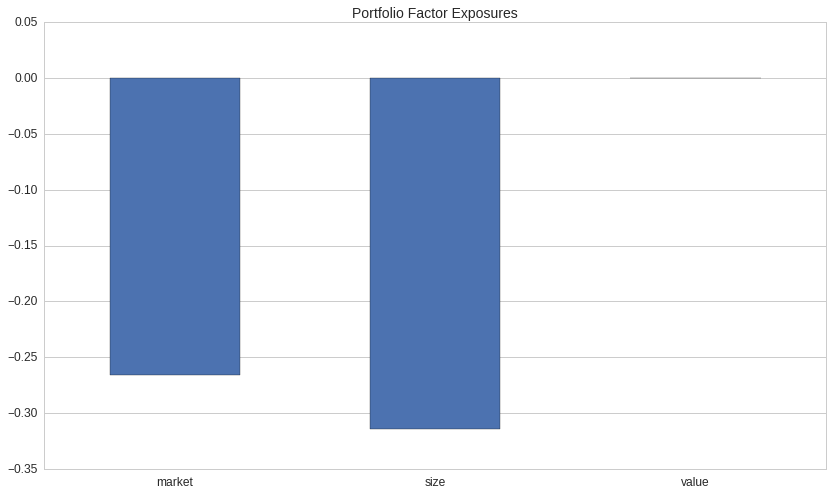

In [27]:
def plot_factor_exposures(pf, factor_loadings):
    return draw_barplot(
        pf.dot(factor_loadings),
        'Portfolio Factor Exposures',
    );
plot_factor_exposures(optimal_sector_neutral_pf, risk_factors);

Our sector neutral portfolio appears to have a strong negative exposure to our `market` and `size` factors. We can force the optimizer to control for these effects using a `FactorExposure` constraint.

In [28]:
print opt.FactorExposure.__doc__


    Constraint requiring bounded net exposure to a set of risk factors.

    Factor loadings are specified as a DataFrame of floats whose columns are
    factor labels and whose index contains Assets. Minimum and maximum factor
    exposures are specified as maps from factor label to min/max net exposure.

    For each column in the loadings frame, we constrain::

        (new_weights * loadings[column]).sum() >= min_exposure[column]
        (new_weights * loadings[column]).sum() <= max_exposure[column]

    Parameters
    ----------
    loadings : pd.DataFrame
         An (assets x labels) frame of weights for each (asset, factor) pair.
    min_exposures : dict or pd.Series
         Minimum net exposure values for each factor.
    max_exposures : dict or pd.Series
         Maximum net exposure values for each factor.
    


In [29]:
MIN_FACTOR_EXPOSURE = -0.01
MAX_FACTOR_EXPOSURE = 0.01

def optimal_portfolio_factor_neutral():
    """
    Calculate the optimal portfolio if we're constrained by exposure, concentration,
    sector, and market/size/value exposures.
    """
    objective = opt.MaximizeAlpha(expected_returns)
    constraints = [
        opt.MaxGrossExposure(1.0),
        opt.PositionConcentration.with_equal_bounds(
            min=MIN_POSITION_WEIGHT, 
            max=MAX_POSITION_WEIGHT,
        ),
        opt.NetPartitionExposure(
            labels=sector_names,
            min_weights={sector: MIN_SECTOR_EXPOSURE for sector in ALL_SECTOR_NAMES},
            max_weights={sector: MAX_SECTOR_EXPOSURE for sector in ALL_SECTOR_NAMES},
        ),
        opt.FactorExposure(
            loadings=risk_factors,
            min_exposures={'market': MIN_FACTOR_EXPOSURE, 
                           'size': MIN_FACTOR_EXPOSURE, 
                           'value': MIN_FACTOR_EXPOSURE},
            max_exposures={'market': MAX_FACTOR_EXPOSURE, 
                           'size': MAX_FACTOR_EXPOSURE, 
                           'value': MAX_FACTOR_EXPOSURE}
        )
    ]
    return opt.calculate_optimal_portfolio(objective, constraints, empty_portfolio)

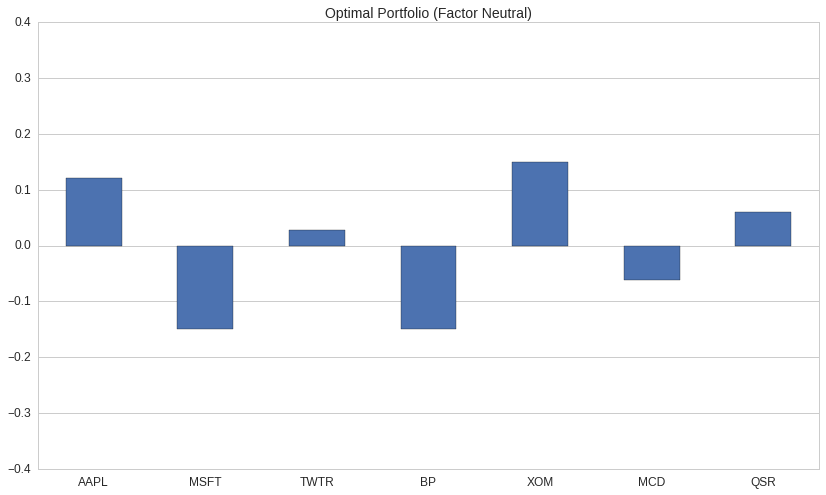

In [30]:
optimal_factor_neutral_pf = optimal_portfolio_factor_neutral()
plot = draw_asset_barplot(
    optimal_factor_neutral_pf, 
    'Optimal Portfolio (Factor Neutral)',
    {'ylim': (-MAX_POSITION_WEIGHT - 0.1, MAX_POSITION_WEIGHT + 0.1)},
)

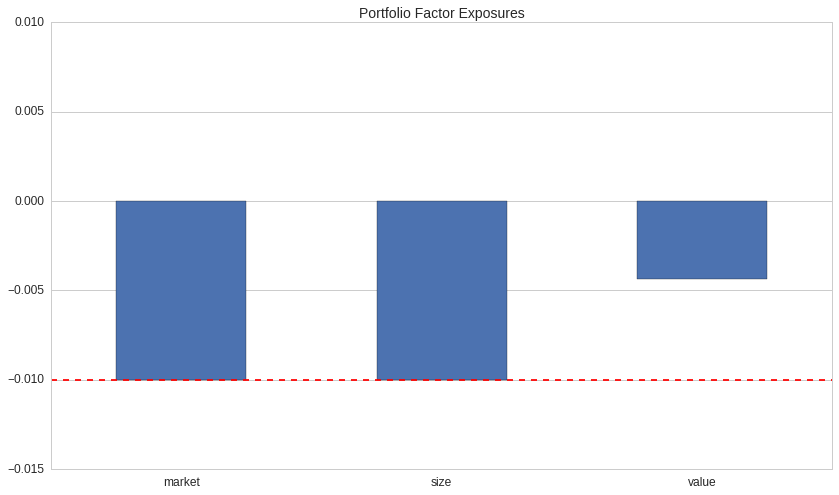

In [31]:
plot = plot_factor_exposures(optimal_factor_neutral_pf, risk_factors);
plot.axhline(MIN_FACTOR_EXPOSURE, color='r', linestyle='dashed')
plot.axhline(MAX_FACTOR_EXPOSURE, color='r', linestyle='dashed');

### Example: Minimize Distance from Target Portfolio with Turnover Constraints

Many algorithms written on Quantopian today perform stock selection via a process other than explicit returns/alpha-modeling. Pair-trading algorithms, for example, work by identifying pairs of [cointegrated](https://www.quantopian.com/posts/quantopian-lecture-series-integration-cointegration-and-stationarity) stocks and entering into a long position in one half of the pair and a short position in the other half of the pair.

For these existing algorithms (or for new algorithms written in a style other than alpha-modeling), it may not be natural to express portfolio construction in terms of an explicit alpha-maximization problem.
Nevertheless, it may still be useful to frame the portfolio construction process as an optimization problem using different objectives and constraints.

Suppose we have an algorithm that trades in four pairs and periodically decides which of the pairs it should allocate capital toward. Via its own internal logic, the algorithm arrives at a "target portfolio" that expresses its ideal holdings. The algorithm wants to trade from its current holdings into its ideal holdings, but it doesn't turn over its entire portfolio at once because doing so may incur excessive transaction costs.  The algorithm also wants to ensure that it maintains a net exposure of 0 in all of its pairs.

We can frame this as an optimization problem as follows:

Minimize the distance between the new portfolio and the ideal portfolio, subject to the constraints that:

1. The long components of our pairs have a weights $\geq$ 0.
2. The short components of our pairs have weights $\leq$ 0.
3. The sum of the weights in each of our pairs is 0.
4. The sum of the absolute values of the changes in weight across all stocks is less than our max turnover.

In fancy math language, we can say the following:

Given a vector $W_{current}$ of current portfolio weights, a vector $W_{ideal}$ of ideal portfolio weights, a maximum turnover rate $T_{max}$, and a list of pairs of long/short stocks $P = [(l_1, s_1), (l_2, s_2), \dots, (l_n, s_n)]$, choose a vector $w$ of weights that solves the following system:

\begin{align}
\text{minimize}&& \\
&&||w - W_{ideal}||_2 \\
\text{subject to}&& \\
&&w_l &\geq 0&& l \in [l_1, l_2, \dots, l_n] \\
&&w_s &\leq 0&& s \in [s_1, s_2, \dots, s_n] \\
&&w_l + w_s &= 0&& (l, s) \in P \\
&&||w - W_{current}||_1 &\leq T_{max}&& \\
\end{align}

(In the above, $||v||_1$ is the $L^1$ norm of $v$, or the ["Taxicab Norm"](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#Taxicab_norm_or_Manhattan_norm), and $||v||_2$ is the $L^2$ norm of $v$, i.e, the standard [Euclidean Norm](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#Euclidean_norm).)

While the mathematical definition of the problem here is a bit hairy, we can express the problem succintly using the `TargetWeights` objective and the `Pair` and `MaxTurnover` constraints.

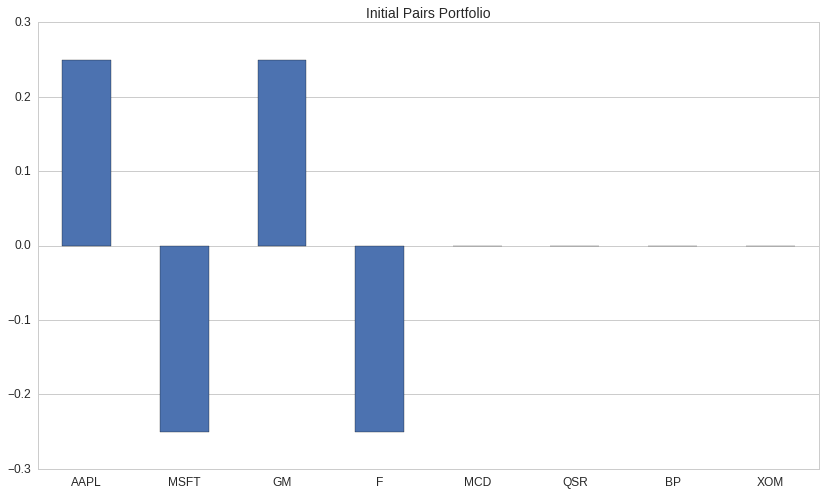

In [32]:
from itertools import chain

pairs = [
    symbols(['AAPL', 'MSFT']),
    symbols(['GM', 'F']),
    symbols(['MCD', 'QSR']),
    symbols(['BP', 'XOM']),
]

# Flatten the list of pairs into a single list for use as an index.
all_pair_stocks = list(chain.from_iterable(pairs))

# Initially allocate half of our capital in the AAPL/MSFT pair and half in the GM/F pair.
initial_pairs_portfolio = pd.Series({
    pairs[0][0]:  0.25,  # AAPL
    pairs[0][1]: -0.25,  # MSFT
    pairs[1][0]:  0.25,  # GM
    pairs[1][1]: -0.25,  # F
}).reindex(
    all_pair_stocks, 
    fill_value=0.0,
)

draw_asset_barplot(initial_pairs_portfolio, 'Initial Pairs Portfolio');

Suppose that after some period of time, our algorithm decides that it wants to exit the `AAPL/MSFT` pair and enter the `MCD/QSR` and `BP/XOM` pairs.  It might calculate a new target portfolio that's equally-weighted between the three new pairs.

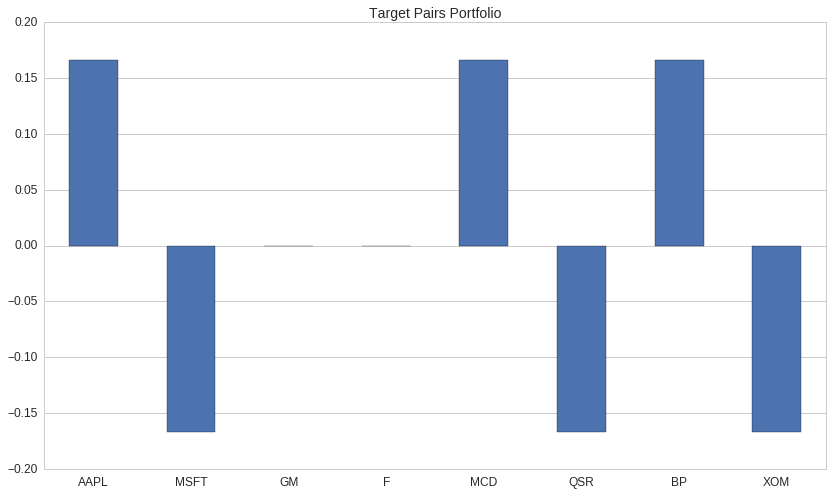

In [33]:
target_pairs_portfolio = pd.Series({
    pairs[0][0]:  0.16666,
    pairs[0][1]: -0.16666,
    pairs[2][0]:  0.16666,
    pairs[2][1]: -0.16666,
    pairs[3][0]:  0.16666,
    pairs[3][1]: -0.16666,
}).reindex(
    all_pair_stocks, 
    fill_value=0.0,
)

draw_asset_barplot(target_pairs_portfolio, 'Target Pairs Portfolio');

If we naively run `calculate_target_weights` using an unconstrained `TargetWeights` objective, we'll get back our target.  But if we supply turnover and pairs constraints, we'll move our capital incrementally out of the current pairs and into the new ones:

In [34]:
print opt.TargetWeights.__doc__


    Objective that minimizes the distance from an already-computed portfolio.

    Parameters
    ----------
    weights : pd.Series[Asset -> float] or dict[Asset -> float]
        Map from asset to target percentage of holdings.

    Notes
    -----
    A target value of 1.0 indicates that 100% of the portfolio's current net
    liquidation value should be held in a long position in the corresponding
    asset.

    A target value of -1.0 indicates that -100% of the portfolio's current net
    liquidation value should be held in a short position in the corresponding
    asset.

    Assets with target values of exactly 0.0 are ignored unless an algorithm
    has an existing position in the given asset.

    If an algorithm has an existing position in an asset and no target weight
    is provided, the target weight is assumed to be zero.
    


In [35]:
opt.TargetWeights(target_pairs_portfolio).math

In [36]:
print opt.Pair.__doc__


    A constraint representing a pair of inverse-weighted stocks.

    Parameters
    ----------
    long : Asset
        The asset to long.
    short : Asset
        The asset to short.
    hedge_ratio : float, optional
        The ratio between the respective absolute values of the long and short
        weights. Required to be greater than 0. Default is 1.0, signifying
        equal weighting.
    tolerance : float, optional
        The amount by which the hedge ratio of the calculated weights is
        allowed to differ from the given hedge ratio, in either direction.
        Required to be greater than or equal to 0. Default is 0.0.
    


In [37]:
print opt.MaxTurnover.__doc__


    A constraint enforcing a maximum turnover for the optimal portfolio.

    Turnover is computed as the sum of the magnitude of the difference in
    weights for each asset in the portfolio, i.e., as::

        sum(abs(new_weights - old_weights))

    Parameters
    ----------
    max : float
        The maximum allowable turnover across the whole portfolio.
    


In [38]:
def migrate_pairs_constrain_turnover(current_pf, target_pf, max_turnover):
    """Calculate a new target portfolio while respecting turnover and pair constraints."""
    objective = opt.TargetWeights(target_pf)
    
    constraints = [opt.Pair(long, short) for long, short in pairs]
    constraints.append(opt.MaxTurnover(max_turnover))
    
    return opt.calculate_optimal_portfolio(
        objective=objective,
        constraints=constraints,
        current_portfolio=current_pf,
    )

In [39]:
# Try changing with the `MAX_TURNOVER` parameter here to see how it affects
# the resulting portfolio!
MAX_TURNOVER = 0.75

migrated_pairs_portfolio = migrate_pairs_constrain_turnover(
    current_pf=initial_pairs_portfolio,
    target_pf=target_pairs_portfolio,
    max_turnover=MAX_TURNOVER,
)

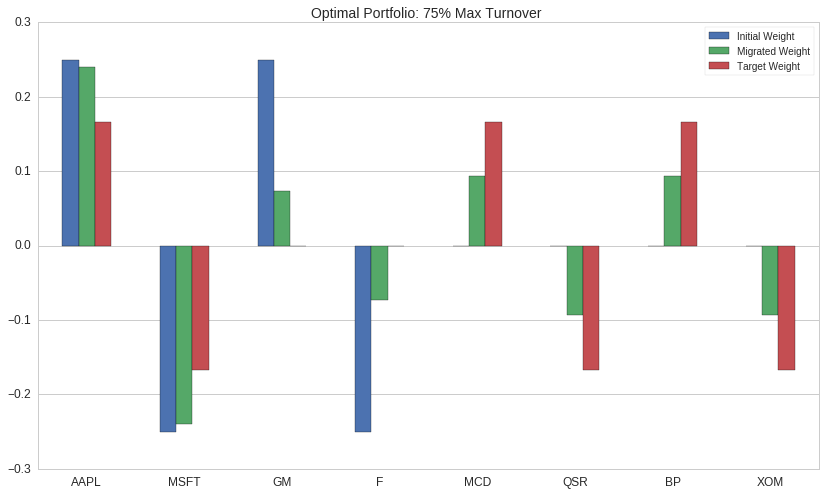

In [40]:
before_and_after_frame = pd.DataFrame(
    {
        'Initial Weight': initial_pairs_portfolio,
        'Migrated Weight': migrated_pairs_portfolio,
        'Target Weight': target_pairs_portfolio,
    },
    # Explicitly set a column order so that the plot below is
    # created in the order we want.
    columns=['Initial Weight', 'Migrated Weight', 'Target Weight']
)

ax = draw_asset_barplot(
    before_and_after_frame,
    # The fancy brace syntax here is a format specification.
    # See https://docs.python.org/2/library/string.html#formatspec for more info.
    'Optimal Portfolio: {0:.0f}% Max Turnover '.format(MAX_TURNOVER * 100),
);

Since the optimizer can't reach its target portfolio without violating the `MaxTurnover` constraint, it attempts to equalize the size of the difference between each stock's output weight and it's target weight.

In [41]:
print "Total Turnover: %f\n" % (migrated_pairs_portfolio - initial_pairs_portfolio).abs().sum()
print "Absolute Difference from Target Weight:\n"
print (migrated_pairs_portfolio - target_pairs_portfolio).abs()

Total Turnover: 0.750000

Absolute Difference from Target Weight:

Equity(24 [AAPL])      0.072915
Equity(5061 [MSFT])    0.072915
Equity(40430 [GM])     0.072915
Equity(2673 [F])       0.072915
Equity(4707 [MCD])     0.072915
Equity(48215 [QSR])    0.072915
Equity(19675 [BP])     0.072915
Equity(8347 [XOM])     0.072915
dtype: float64


# Debugging and Diagnostics

One issue users may encounter when using the Optimize API is that it’s possible to accidentally ask the optimizer to solve problems for which no solution exists. This can happen, for example, if we provide the optimizer with two mutually-exclusive constraints.

If the optimizer determines that no portfolio can satisfy all the constraints we've provided, it raises an `InfeasibleConstraints` error. Debugging `InfeasibleConstraints` can be tricky: since different portfolios might violate different constraints, there isn't necessarily a single constraint we can point to as being the source of infeasibility.

One observation that can help us when we encounter infeasible constraints is to note that there are certain "special" portfolios that we might have expected to pass our constraints. We can often figure out the problem with our optimization by examining the constraints that were violated by these special portfolios.

When an `InfeasibleConstraints` error is raised, the optimizer examines a small number of these portfolios and produces an error message detailing the constraints that were violated by each tested portfolio. The portfolios current exampled by the optimizer for diagnostics are:

1. The current portfolio.
2. An empty portfolio.
3. The target portfolio (only applies when using `TargetWeights`).

### Example:

Suppose we have a portfolio that currently has long and short positions worth 10% of our portfolio value in `AAPL` and `MSFT`, respectively.

In [42]:
AAPL, MSFT = symbols(['AAPL', 'MSFT'])
current_weights = pd.Series({AAPL: 0.1, MSFT: -0.1})

We use `TargetWeights` as our objective to try to close the `MSFT` position.

In [43]:
objective = opt.TargetWeights({AAPL: 0.1, MSFT: 0.0})

We also define three mutually-exclusive constraints:

- Our portfolio must be dollar-neutral (i.e., it must have the same amount invested long and short). Our target portfolio violates this constraint.
- Fixed weight in `AAPL`. This simulates what might happen if `AAPL` were subject to a trading halt during the day. An empty portfolio would violate this constraint.
- Cannot short `MSFT`. The current portfolio violates this constraint.

In [44]:
impossible_constraints = [
    opt.DollarNeutral(tolerance=0.01), 
    opt.FixedWeight(AAPL, 0.1),
    opt.LongOnly(MSFT),
]

In [45]:
opt.calculate_optimal_portfolio(objective, impossible_constraints)

InfeasibleConstraints: The attempted optimization failed because no portfolio could be found that
satisfied all required constraints.

The following special portfolios were spot checked and found to be in violation
of at least one constraint:

Target Portfolio (as provided to TargetWeights):

   Would violate DollarNeutral() because:
      Net exposure (0.1) would be greater than max net exposure (0.01).

Current Portfolio (at the time of the optimization):

   Would violate FixedWeight(Equity(24 [AAPL])) because:
      New weight (0.0) would not equal required weight (0.1).

Empty Portfolio (no positions):

   Would violate FixedWeight(Equity(24 [AAPL])) because:
      New weight (0.0) would not equal required weight (0.1).

Occasionally it can useful to interrogate the results of an optimize error programatically.  The `run_optimization` entrypoint makes this possible.

`run_optimization` performs the same calculation as `calculate_optimal_portfolio`, but it returns an `OptimizationResult` which contains additional information besides the computed portfolio.

In [46]:
# Run an optimization with no constraints to get a successful result.
success_result = opt.run_optimization(objective, [])
print "Success:", success_result

# Re-run the impossible optimization to see a failed result.
fail_result = opt.run_optimization(objective, impossible_constraints)
print "Failure:", fail_result

Success: OptimizationResult(success=True, status='optimal')
Failure: OptimizationResult(success=False, status='infeasible')


When an optimization succeeds, the result's `success` attribute is set to `True`, and the new optimal portfolio is stored as `result.new_weights`.  If the result failed, `success` is `False`, and `result.new_weights` is `None`.

In [47]:
print "Success:", success_result.success
print "New Portfolio:", success_result.new_weights

Success: True
New Portfolio: Equity(24 [AAPL])    0.1
dtype: float64


In [48]:
print "Success:", fail_result.success
print "New Portfolio:", fail_result.new_weights

Success: False
New Portfolio: None


The result object also has a `print_diagnostics` method, which can be used to print the same debugging information displayed by `InfeasibleConstraints`. This can be useful for debugging cases where an optimization is **succeeding**, but not producing the results expected.

In [49]:
success_result.print_diagnostics()

Target Portfolio (as provided to TargetWeights):
  All Constraints Satisfied


In [50]:
fail_result.print_diagnostics()

Target Portfolio (as provided to TargetWeights):

   Would violate DollarNeutral() because:
      Net exposure (0.1) would be greater than max net exposure (0.01).

Current Portfolio (at the time of the optimization):

   Would violate FixedWeight(Equity(24 [AAPL])) because:
      New weight (0.0) would not equal required weight (0.1).

Empty Portfolio (no positions):

   Would violate FixedWeight(Equity(24 [AAPL])) because:
      New weight (0.0) would not equal required weight (0.1).


# Review

- The **Optimize API** is a suite of tools for solving portfolio optimization problems on Quantopian. It provides a high-level, declarative, finance-oriented interface to Python's excellent ecosystem of numerical optimization libraries.

- Users interact with the Optimize API by passing an `Objective` and a list of `Constraint`s to one of three optimize entrypoints:
  - The primary entrypoint in research is `calculate_optimal_portfolio`. 
  - The primary entrypoint in algorithms is `order_optimal_portfolio`.
  - `run_optimization` is a lower-level entrypoint primarily useful for debugging.
  
- When an optimization fails because of `InfeasibleConstraints`, the optimizer provides information about the failed optimization by testing interesting portfolios for constraint information.